In [1]:
from datetime import datetime
from utils.binaries import *
from utils.plotting import *
import uproot

13:34:52 [INFO] utils          -- ( +2657ms) -- import logging
13:34:52 [INFO] utils.binaries -- (  +169ms) -- import numpy as np
13:34:52 [INFO] utils.binaries -- (    +9ms) -- import uncertainties
13:34:53 [INFO] utils.binaries -- (  +513ms) -- import pandas as pd
13:34:53 [INFO] utils.binaries -- (    +8ms) -- import binaries.tools as tools
13:34:54 [INFO] utils.plotting -- (  +827ms) -- import matplotlib.pyplot as plt
13:34:54 [INFO] utils.plotting -- (  +743ms) -- import seaborn as so
13:34:54 [DBUG] utils.plotting -- (   +11ms) -- font size set to 9.5
13:34:54 [DBUG] utils.plotting -- (    +1ms) -- label size set to 13.0
13:34:54 [DBUG] utils.plotting -- (    +0ms) -- figure size set to [6.6, 3.3]
13:34:54 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
13:34:54 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
13:34:54 [INFO] utils.plotting -- (    +9ms) -- import plotting.tools as plot


In [2]:
def get_start_stop_variance(path):

    # correspondence used:
    # HEAT 1 - Coihueco 6
    # Heat 2 - Coihueco 5
    # HEAT 3 - Coihueco 4

    file = uproot.open(f'{path}:AugerUpTime')
    variances = np.array(file['ADCVariance'].array(), dtype=float)[:,-6:,:]
    shutter_open_fraction = np.array(file['ShutterFraction8ADC'].array())[:,-6:]
    variances *= shutter_open_fraction[:, :, np.newaxis]

    indices = [i for i, var in enumerate(variances) if np.sum(var) != 0]
    start, stop = file['uptime_gpsStart'].array(), file['uptime_gpsStop'].array()
    return start[indices], stop[indices], variances[indices]

def get_calibration_constant(date, method):

    results = '/cr/data01/filip/xy-calibration/results/'

    # force preclean usage
    # date = '2023-07'

    # force postclean usage
    # date = '2023-11'

    if date < '2023-11':        # before mirror cleaning
        # print('before MC')
        heat1_run = '6020x'
        heat2_run = '6025'
        heat3_run = '6031x'


    else:                       # after mirror cleaning
        # print('after MC')
        heat1_run = '6070'
        heat2_run = '6075'
        heat3_run = '6066'
    
    co6_run = '15925x'
    co5_run = '15984x'
    co4_run = '15934x'

    heat1 = pd.read_csv(f'{results}/outCorr_{heat1_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    heat2 = pd.read_csv(f'{results}/outCorr_{heat2_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    heat3 = pd.read_csv(f'{results}/outCorr_{heat3_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])

    co6 = pd.read_csv(f'{results}/outCorr_{co6_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    co5 = pd.read_csv(f'{results}/outCorr_{co5_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    co4 = pd.read_csv(f'{results}/outCorr_{co4_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    
    get_raw = lambda run : np.ones(440)
    get_cala = lambda run : run.stdCalib.values
    get_xy = lambda run : run.calibConstCorr.values

    match method.lower():
        case 'xy': get_calibration_constants = get_xy
        case 'cala': get_calibration_constants = get_cala
        case _: get_calibration_constants = get_raw

    return [get_calibration_constants(run) for run in [co4, co5, co6, heat1, heat2, heat3]]

def to_month_dict(start, stop, var):

    month_dict = {}
    GPS_OFFSET = 315964800
    avg = [datetime.fromtimestamp(x) for x in 0.5 * (start + stop) + GPS_OFFSET]

    for t, var in zip(avg, var):
        key = t.strftime('%Y-%m')

        try:
            _ = month_dict[key]
        except KeyError:
            month_dict[key] = {'var' : np.zeros((6, 440)), 'n' : 0}

        month_dict[key]['n'] += 1
        month_dict[key]['var'] += var

    for key, value in month_dict.items():
        month_dict[key]['var'] = value['var']

    return month_dict

def combine_dict(dict1, dict2):

    combined_dict = {}
    for key in set(list(dict1.keys()) + list(dict2.keys())):
        combined_dict[key] = {}

        vals1 = dict1.get(key, {'var' : np.zeros((6, 440)), 'n' : 0})
        vals2 = dict2.get(key, {'var' : np.zeros((6, 440)), 'n' : 0})
        combined_dict[key]['var'] = vals1['var'] + vals2['var']
        combined_dict[key]['n'] = vals1['n'] + vals2['n']

    return combined_dict


In [3]:
from datetime import datetime
from utils.Auger.FD import PixelPlot
from matplotlib.gridspec import GridSpec

files = [#'2022-10-01-12utc.root',
        #  '2023-03-01-12utc.root',
        #  '2023-04-01-12utc.root',
        #  '2023-05-01-12utc.root',
        #  '2023-06-01-12utc.root',
        #  '2023-07-01-12utc.root', 
         '2023-08-01-12utc.root', 
         '2023-09-01-12utc.root', 
         '2023-10-01-12utc.root', 
         '2023-11-01-12utc.root', 
         '2023-12-01-12utc.root',
         '2024-01-01-12utc.root'
         ]

variances = {}
for file in files:
    start, stop, var = get_start_stop_variance(file)
    this_one = to_month_dict(start, stop, var)
    variances = combine_dict(variances, this_one)

<Figure size 3960x1980 with 0 Axes>

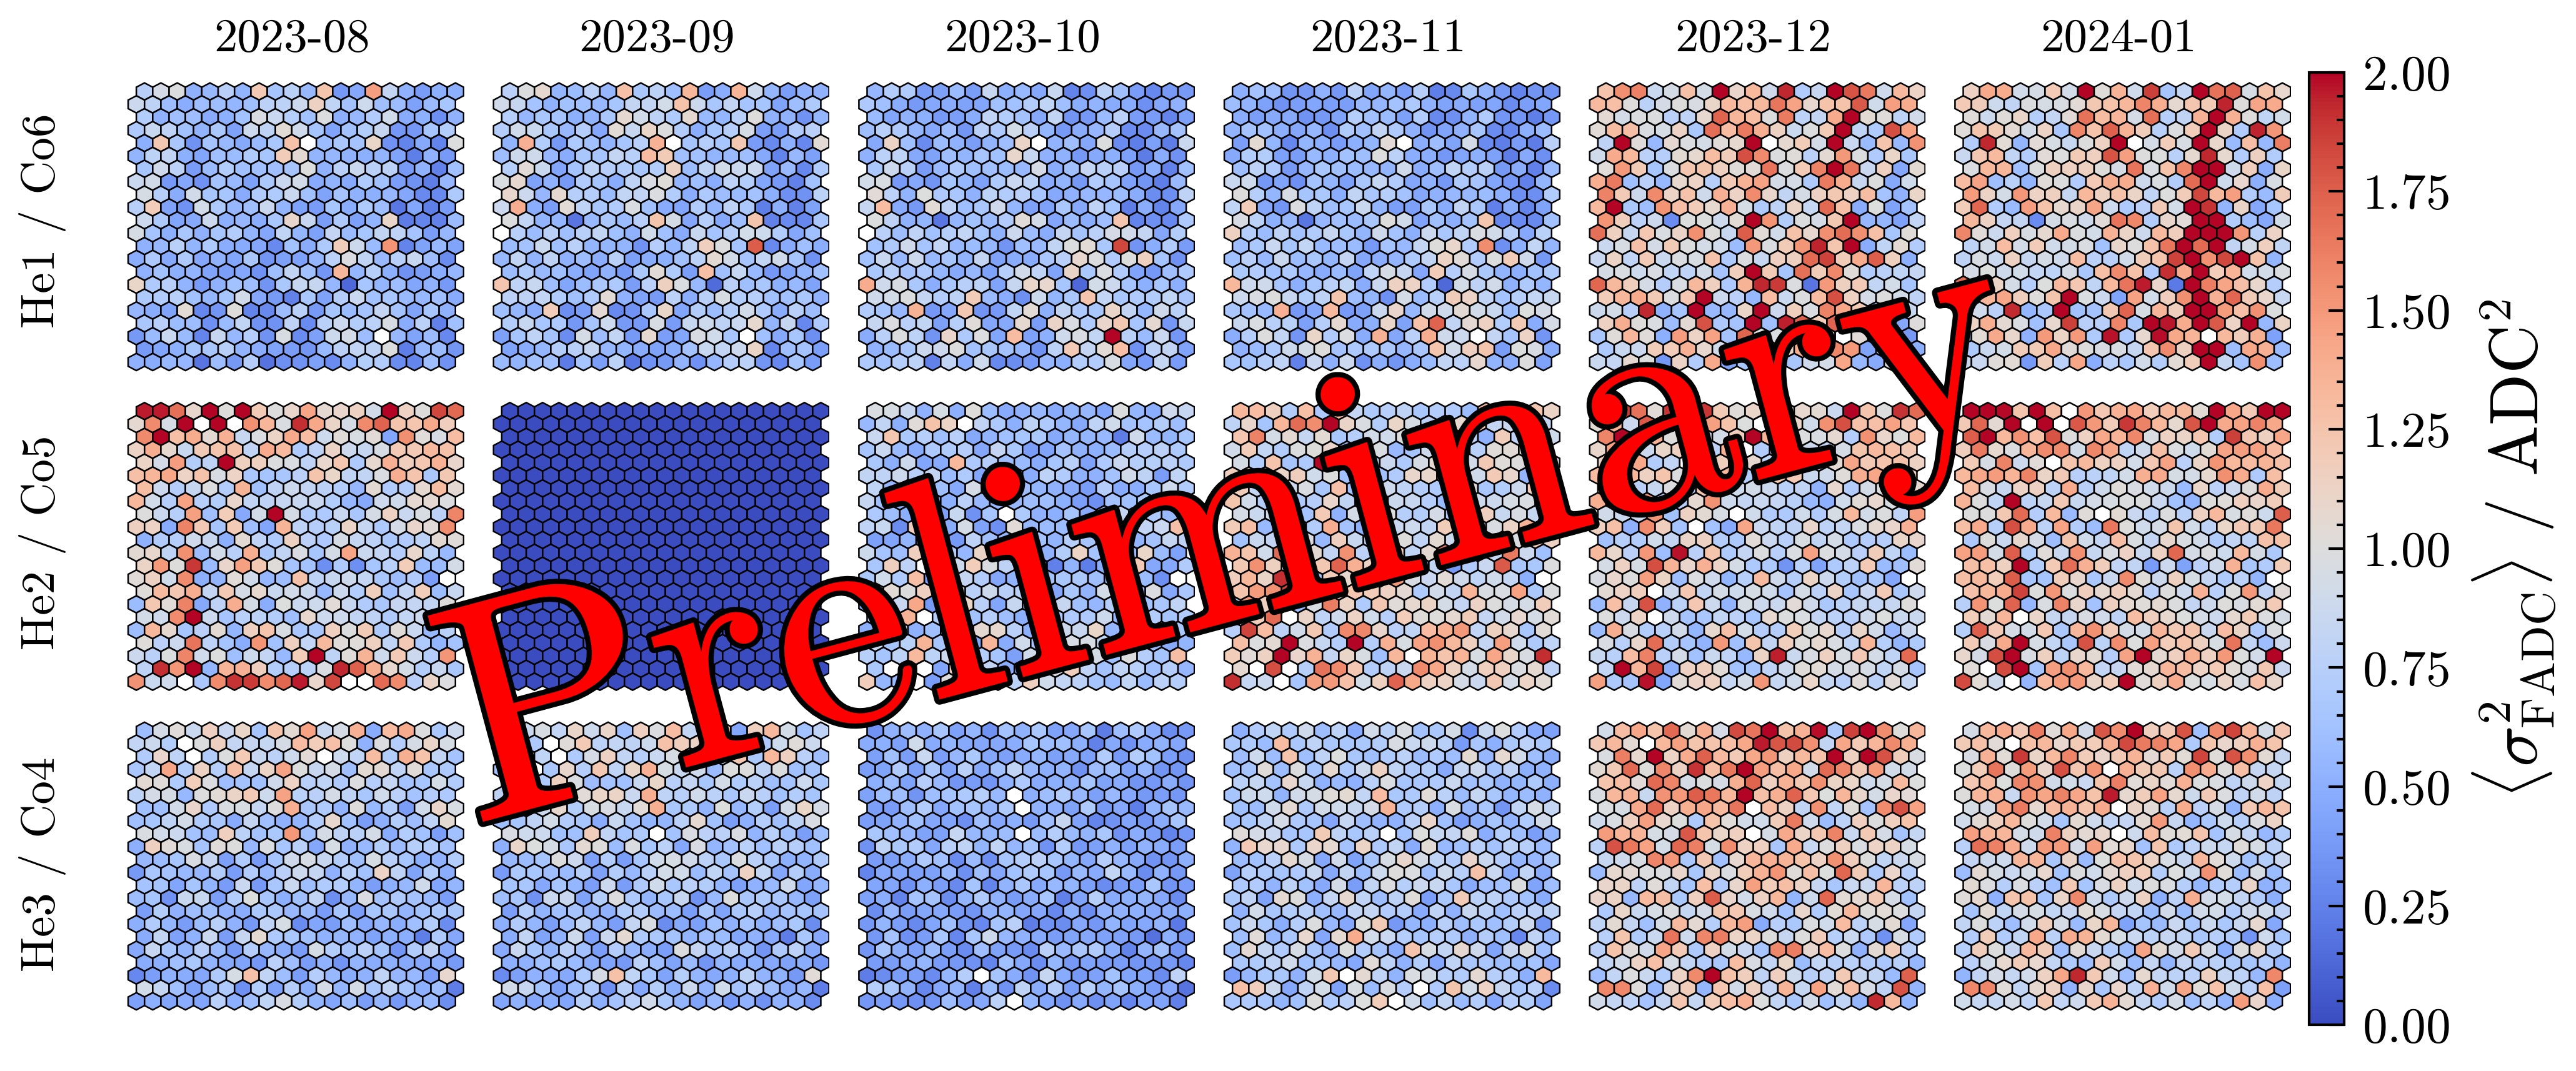

In [14]:
# fig1, laxes = plt.subplots(len(files), 1, sharey=True)
# fig1.text(.02, 0.5, 'Variance / $\mathrm{ADC}^2$', rotation=90,
#           fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 18})
plt.subplots_adjust(hspace=0.6)

fig2 = plt.figure()
gs = GridSpec(
        3,
        len(files) + 1,
        figure=fig2,
        width_ratios=[1 for _ in files] + [0.1],
        height_ratios = [1/3, 1/3, 1/3],
    )
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.02)
fig2.text(.02, 0.76, 'He1 / Co6', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})
fig2.text(.02, 0.5, 'He2 / Co5', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})
fig2.text(.02, 0.24, 'He3 / Co4', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})

method = '_'


if method == '_':
    vmin, vmax = 0, 50
    name = 'raw_variance'
    symbol = ''
elif method == 'cala':
    vmin, vmax = 30, 140
    name = 'CalA_normalized'
    symbol = 'K_\mathrm{D}'
elif method == 'xy':
    vmin, vmax = 30, 140
    name = 'XY_normalized'
    symbol = 'K_\mathrm{XY}'

vmin, vmax = 0, 2
means_before, means_after = [], []

sorted_keys = list(variances.items())
sorted_keys.sort()
for col, (key, val) in enumerate(sorted_keys):

    mean_var_for_month = val['var'] / val['n']
    co4, co5, co6 = mean_var_for_month[:3]
    he1, he2, he3 = mean_var_for_month[3:]

    # normalize with calibration constants
    calibration_constants = get_calibration_constant(key, method)
    co4_cal, co5_cal, co6_cal, he1_cal, he2_cal, he3_cal = calibration_constants

    co4 *= co4_cal
    co5 *= co5_cal
    co6 *= co6_cal
    he1 *= he1_cal
    he2 *= he2_cal
    he3 *= he3_cal

    ratios = [he1 / co6, he2 / co5, he3 / co4]
    ax1, ax2, ax3 = [fig2.add_subplot(gs[i,col]) for i in range(3)]

    # remove outliers
    for i, ratio in enumerate(ratios):
        mu, sigma = ratio.mean(), ratio.std()
        ratios[i][np.abs(ratio - mu) > 3 * sigma] = np.nan

    PixelPlot(ratios[0], 'coolwarm', ax=ax1, lw=0.3, vmin=vmin, vmax=vmax)
    PixelPlot(ratios[1], 'coolwarm', ax=ax2, lw=0.3, vmin=vmin, vmax=vmax)
    PixelPlot(ratios[2], 'coolwarm', ax=ax3, lw=0.3, vmin=vmin, vmax=vmax)
    ax1.set_title(key, pad=4, fontsize=9)

#     # if file[:7] < '2023-11':
#     #     if file[:7] in ['2023-09', '2023-07']:                      # skip heat 2 due to UpTime being down
#     #         heat1, heat2, heat3 = np.mean(means, axis=1)
#     #         heat2 = np.nan
#     #         means_before.append([heat1, heat2, heat3])        
#     #     else:
#     #         means_before.append(np.mean(means, axis=1))
#     # else:
#     #     means_after.append(np.mean(means, axis=1))

#     ax1.text(0.09, 0.93, fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}{symbol}\rangle = {np.nanmean(ratios[0]):.2f}$', c='k', fontdict={'fontsize' : 5, 'ha' : 'left', 'va' : 'top', 'weight' : 'bold'}, transform=ax1.transAxes)
#     ax2.text(0.09, 0.93, fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}{symbol}\rangle = {np.nanmean(ratios[1]):.2f}$', c='k', fontdict={'fontsize' : 5, 'ha' : 'left', 'va' : 'top', 'weight' : 'bold'}, transform=ax2.transAxes)
#     ax3.text(0.09, 0.93, fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}{symbol}\rangle = {np.nanmean(ratios[2]):.2f}$', c='k', fontdict={'fontsize' : 5, 'ha' : 'left', 'va' : 'top', 'weight' : 'bold'}, transform=ax3.transAxes)

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
norm = Normalize(vmin, vmax)

fig2.colorbar(ScalarMappable(norm, 'coolwarm'), cax=fig2.add_subplot(gs[:, len(files)]),
              label=fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}{symbol}\rangle$ / $\mathrm{{ADC}}^2$')
plot.preliminary(fig2)



# fig2.savefig(f'/cr/users/filip/plots/XY-heat/NSB/{name}_shutter_corrected.png', bbox_inches='tight')
# fig1.savefig('/cr/users/filip/plots/XY-heat/NSB/time_series.png', bbox_inches='tight')

In [ ]:
test = {'n' : 0, 'asdasd' : 10}

In [ ]:
print(list(test.keys()))